### learnings

- Never test on the oversampled or undersampled dataset

- If we want to implement cross validation, remember to oversample or undersample your
training data during cross-validation, not before!

- Don't use accuracy score as a metric with imbalanced datasets (will be usually high and misleading),
instead use f1-score, precision/recall score, or Precision-Recall Curve (AUPRC)

- There are variables from PCA, the original variables must be scaled before applying PCA

### imports

In [1]:
import kagglehub
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
from dotenv import load_dotenv

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

# Metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    accuracy_score,
    classification_report
    )

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedShuffleSplit
import warnings
warnings.filterwarnings("ignore")

load_dotenv()

2025-05-19 15:22:16.644548: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-19 15:22:16.645970: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-19 15:22:16.653533: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-19 15:22:16.676908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747664536.708381   26408 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747664536.71

True

### download & load the dataset

In [2]:
# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print(f"Dataset downloaded to: {path}")
df = pd.read_csv(f"{path}/creditcard.csv")

Dataset downloaded to: /home/yezer/projects/credit-fraud-detector/datasets/datasets/mlg-ulb/creditcardfraud/versions/3


### explore the dataset


In [ ]:
print("df.shape", df.shape)
df.head()

In [ ]:
df.describe()

In [ ]:
print(f"- total null values:{df.isnull().sum().sum()}")
print(f"- % null values:{df.isnull().sum().sum()*100/df.notnull().sum().sum()}")
print(f"- 99% of transactions are under ${df['Amount'].quantile(0.99):.2f}")
print(f"\n- % fraud transactions:{100*df[df.Class==1].shape[0]/df.shape[0]:.2f}")
print(f"- fraud transactions with amount 0 -> {df[(df.Class==1) & (df.Amount==0.0)].shape[0]}")
print(f"- fraud transactions max amount -> {df[df.Class==1]['Amount'].max()}")
print(f"\n- % correct transactions:{100*df[df.Class==0].shape[0]/df.shape[0]:.2f}")
print(f"- correct transactions with amount 0 -> {df[(df.Class==0) & (df.Amount==0.0)].shape[0]}")
print(f"- correct transactions max amount -> {df[df.Class==0]['Amount'].max()}")


In [ ]:
# Plot class distribution
plt.figure(figsize=(6, 3))
colors = ["#000080", "#DF0101"]  # Dark blue for non-fraud, Red for fraud
sns.countplot(x='Class', data=df, palette=colors)
plt.title('Class Distribution\n(0: No Fraud || 1: Fraud)', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


In [ ]:
# Create figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(18,4))

# Get transaction amounts and times
amount_val = df['Amount'].values
time_val = df['Time'].values

# Plot distribution of transaction amounts
sns.histplot(amount_val, ax=ax[0], color='r', kde=True)
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), np.percentile(amount_val, 99)])  # Limit x-axis to 99th percentile

# Plot distribution of transaction times 
sns.histplot(time_val, ax=ax[1], color='b', kde=True)
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

### scaling

- In this phase of our kernel, we will first scale the columns comprise of Time and Amount .
Time and amount should be scaled as the other columns

In [3]:
# RobustScaler is less prone to outliers.
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)
df.head()


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


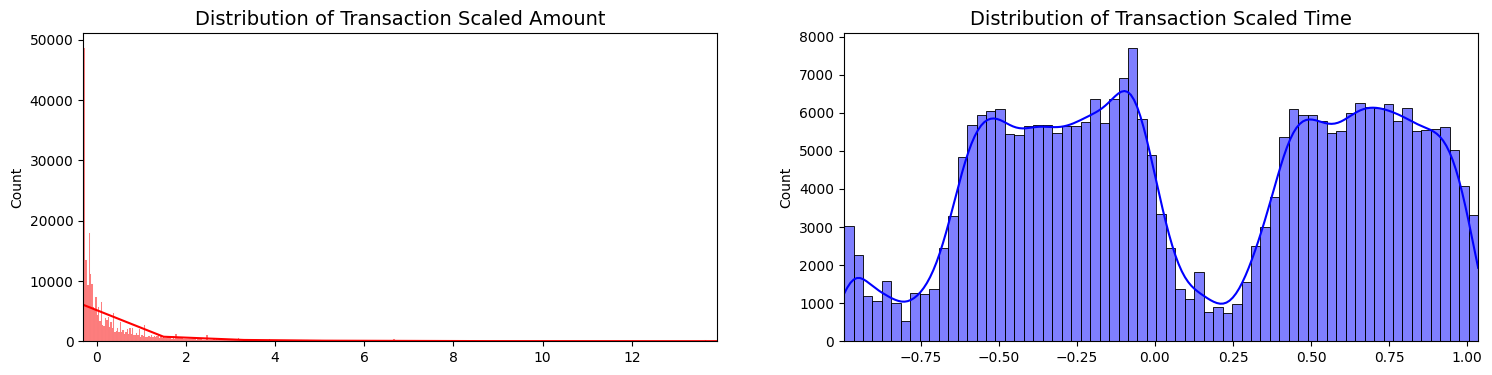

In [6]:
# Create figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(18,4))

# Get transaction amounts and times
amount_val = df['scaled_amount'].values
time_val = df['scaled_time'].values

# Plot distribution of transaction amounts
sns.histplot(amount_val, ax=ax[0], color='r', kde=True)
ax[0].set_title('Distribution of Transaction Scaled Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), np.percentile(amount_val, 99)])  # Limit x-axis to 99th percentile

# Plot distribution of transaction times 
sns.histplot(time_val, ax=ax[1], color='b', kde=True)
ax[1].set_title('Distribution of Transaction Scaled Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

### baseline model (AUPRC metric)

- Run Cross-Validation Across Multiple Seeds (For Robustness). Try several seeds and observe the distribution of metrics. This tells you how sensitive your model is to random splits. Cross-validation is primarily a technique to get a reliable estimate of how your model will perform on unseen data and to select the best model/hyperparameters. Once you've made that selection, you want your final model to learn from as much data as possible. Training on the full dataset allows the model to see all available examples, which can lead to a potentially more robust and slightly better-performing model.

- Use this to check stability across seeds rather than choosing a single “best” one.

- Once Satisfied, Fix One Seed for Reproducibility

- If the performance is not stable across seeds, your dataset may be:Too small or too noisy or extremely sensitive to the splits.

- What Does AUPRC Measure?
It quantifies the trade-off between:
Precision = How many of the predicted positives are actually positive
Recall = How many of the actual positives are correctly predicted
The Precision-Recall Curve shows this trade-off at all possible classification thresholds (e.g. values over 0.1 are fraud, 02, 0.3, ...). The area under that curve
(AUPRC) summarizes the model’s performance in one number.

- AUPRC is better for imbalanced datasets, however AUC-ROC is better for balanced ones. AUPRC focuses only on the positive class, so it tells you how well the model is identifying the rare events (e.g., hotel reservations in your case), which is what you care about most.

- AUPRC summarizes performance over all thresholds — to actually deploy a model, you still need to choose a specific threshold based on business trade-offs between precision and recall.

- F1 score is a single metric that provides a balanced measure of the model's performance by considering both precision and recall. It is the harmonic mean of precision and recall. F1 Score = 1: This indicates perfect precision and perfect recall. The model correctly identifies all positive instances and makes no incorrect positive predictions. The F1 score is particularly useful when dealing with imbalanced datasets (where one class has significantly more instances than the other).

In [7]:
all_auprc_scores = []
all_f1_scores = []

X = df.drop("Class", axis=1)
y = df["Class"]

for seed in [1, 7, 21, 42, 100, 123]:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    fold_auprcs = []
    fold_f1s = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = LogisticRegression(random_state=seed)
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        y_pred = model.predict(X_val)

        auprc = average_precision_score(y_val, y_pred_proba)
        f1 = f1_score(y_val, y_pred)
        fold_auprcs.append(auprc)
        fold_f1s.append(f1)

    mean_auprc = np.mean(fold_auprcs)
    std_auprc = np.std(fold_auprcs)
    mean_f1 = np.mean(fold_f1s)
    std_f1 = np.std(fold_f1s)
    print(
        f"Seed {seed} - Mean AUPRC: {mean_auprc:.4f} std: {std_auprc:.4f}, Mean F1: {mean_f1:.4f} std: {std_f1:.4f}"
    )
    all_auprc_scores.append((seed, mean_auprc))
    all_f1_scores.append((seed, mean_f1))

Seed 1 - Mean AUPRC: 0.7543 std: 0.0375, Mean F1: 0.7304 std: 0.0215
Seed 7 - Mean AUPRC: 0.7580 std: 0.0511, Mean F1: 0.7213 std: 0.0322
Seed 21 - Mean AUPRC: 0.7598 std: 0.0095, Mean F1: 0.7262 std: 0.0271
Seed 42 - Mean AUPRC: 0.7563 std: 0.0226, Mean F1: 0.7301 std: 0.0321
Seed 100 - Mean AUPRC: 0.7567 std: 0.0495, Mean F1: 0.7226 std: 0.0377
Seed 123 - Mean AUPRC: 0.7559 std: 0.0243, Mean F1: 0.7203 std: 0.0430


In [8]:
# Generate Random Classifier Baseline
# Create random predictions and calculate AUPRC and F1 to compare with our model
random_preds = np.random.random(len(y))
random_preds_binary = (random_preds > 0.5).astype(int)  # Convert to binary predictions for F1
random_auprc = average_precision_score(y, random_preds)
random_f1 = f1_score(y, random_preds_binary)
print(f'\nRandom Classifier AUPRC: {random_auprc:.4f}')
print(f'Random Classifier F1: {random_f1:.4f}')


Random Classifier AUPRC: 0.0017
Random Classifier F1: 0.0032


##### model01 - training logistic reg. with the dataset

Fold 1 - Train AUPRC: 0.7769 - Validation AUPRC: 0.7175
Fold 2 - Train AUPRC: 0.7691 - Validation AUPRC: 0.7598
Fold 3 - Train AUPRC: 0.7608 - Validation AUPRC: 0.7775
Fold 4 - Train AUPRC: 0.7577 - Validation AUPRC: 0.7792
Fold 5 - Train AUPRC: 0.7708 - Validation AUPRC: 0.7478

Mean AUPRC: 0.7563 (+/- 0.0453)

AUPRC on the full dataset (baseline model): 0.7656


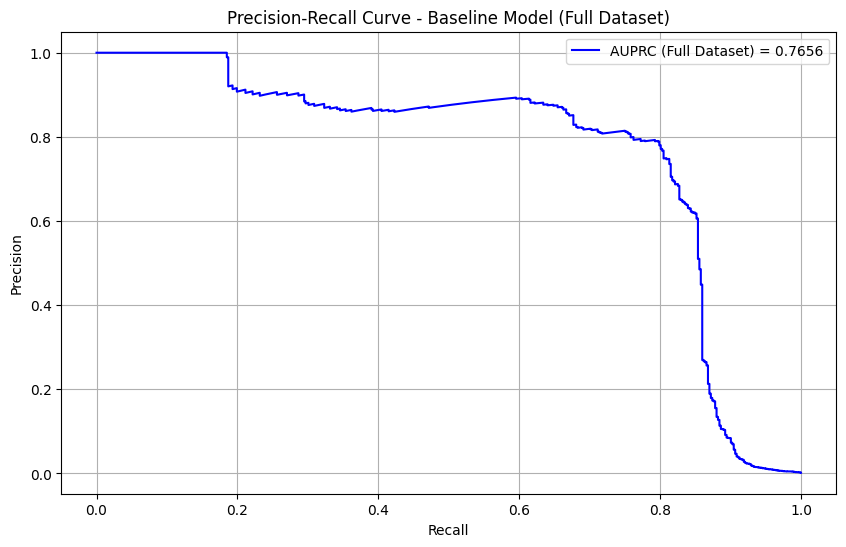

In [6]:
# Prepare data for modeling
X = df.drop('Class', axis=1)
y = df['Class']

# Initialize stratified k-fold cross validation
# The critical part is that you do set a random_state to a fixed integer when you
# want your code to produce the same results across multiple runs.
# If you don't set a random_state (or set it to None)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize logistic regression as baseline model
lr_model = LogisticRegression(random_state=42)

# Lists to store precision, recall, AUPRC and F1 scores
precision_scores = []
recall_scores = []
auprc_scores = []

# Perform cross validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Train model
    lr_model.fit(X_train, y_train)
    
    # Get predictions
    y_pred_proba = lr_model.predict_proba(X_val)[:, 1]
    y_pred = lr_model.predict(X_val)
    
    # Calculate metrics for validation set
    precision_val, recall_val, _ = precision_recall_curve(y_val, y_pred_proba)
    auprc_val = average_precision_score(y_val, y_pred_proba)
    auprc_scores.append(auprc_val) # Store validation AUPRC for mean calculation

    # Calculate metrics for training set
    y_train_pred_proba = lr_model.predict_proba(X_train)[:, 1]
    auprc_train = average_precision_score(y_train, y_train_pred_proba)
    
    print(f'Fold {fold + 1} - Train AUPRC: {auprc_train:.4f} - Validation AUPRC: {auprc_val:.4f}')

print('\nMean AUPRC: {:.4f} (+/- {:.4f})'.format(
    np.mean(auprc_scores), 
    np.std(auprc_scores) * 2
))

# Train model on the entire dataset
lr_model.fit(X, y)

# Get predictions on the entire dataset
y_pred_proba_full = lr_model.predict_proba(X)[:, 1]

# Calculate AUPRC on the entire dataset
auprc_full = average_precision_score(y, y_pred_proba_full)
print(f'\nAUPRC on the full dataset (baseline model): {auprc_full:.4f}')

# Calculate Precision-Recall curve for the full dataset
precision_full, recall_full, _ = precision_recall_curve(y, y_pred_proba_full)

# Plot Precision-Recall curve for the full dataset
plt.figure(figsize=(10, 6))
plt.plot(recall_full, precision_full, color='blue', label=f'AUPRC (Full Dataset) = {auprc_full:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Baseline Model (Full Dataset)')
plt.legend()
plt.grid(True)
plt.show()



Optimal threshold for perfect precision: 0.9987
At this threshold:
Precision: 0.9
Recall: 0.2755


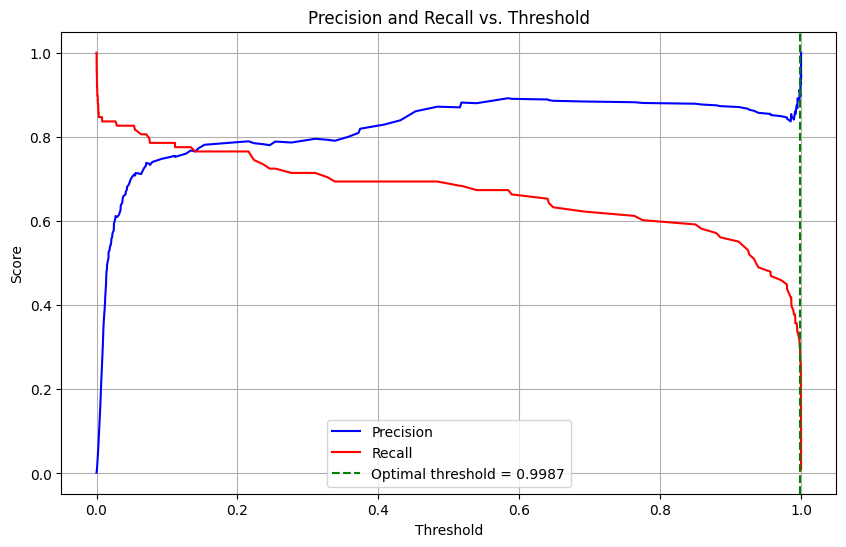

In [7]:
# Get precision-recall curve data from last fold
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)

# Find the largest threshold where precision is still 0.99
# We'll look through the precision values from highest threshold to lowest
max_recall_at_full_precision = 0
optimal_threshold = 1.0
needed_precision = 0.9

for p, r, t in zip(precision[:-1], recall[:-1], thresholds):
    if p == needed_precision and r > max_recall_at_full_precision:
        max_recall_at_full_precision = r
        optimal_threshold = t

print(f"\nOptimal threshold for perfect precision: {optimal_threshold:.4f}")
print(f"At this threshold:")
print(f"Precision: {needed_precision}")
print(f"Recall: {max_recall_at_full_precision:.4f}")

# Plot precision and recall curves vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], 'b-', label='Precision')
plt.plot(thresholds, recall[:-1], 'r-', label='Recall')
plt.axvline(x=optimal_threshold, color='g', linestyle='--', 
            label=f'Optimal threshold = {optimal_threshold:.4f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
# Example of making predictions with a threshold of 0.8
# Let's simulate some new transaction data (using the same features as training data)
new_transaction = X.iloc[0:1]  # Using first row as example new transaction
print(f"fraud: {y.iloc[0:1].values}")

# Get probability predictions 
# Get probability predictions from logistic regression model
# predict_proba returns probabilities for both classes [P(class=0), P(class=1)]
# We take [:, 1] to get only the probability of fraud (class 1)
pred_proba = lr_model.predict_proba(new_transaction)[:, 1]  # Returns probability of fraud between 0 and 1
print(pred_proba)

# Apply threshold of 0.8
threshold = 0.8
prediction = (pred_proba >= threshold).astype(int)

print("Probability of fraud:", pred_proba[0])
print(f"Prediction (threshold={threshold}):", prediction[0])
print("Actual prediction would be fraud" if prediction[0] == 1 else "Actual prediction would be legitimate")


fraud: [0]
[0.00077777]
Probability of fraud: 0.0007777735244232094
Prediction (threshold=0.8): 0
Actual prediction would be legitimate


### Random undersampling technique

- "Random Under Sampling" which basically consists of removing data in order to have a more balanced dataset and thus avoiding our models to overfitting.

- we need to also create a sub sample of the dataframe in order to have an equal amount of Fraud and
Non-Fraud cases, helping our algorithms better understand patterns that determines whether a transaction
is a fraud or not.

- What is a sub-Sample?
In this scenario, our subsample will be a dataframe with a 50/50 ratio of fraud and non-fraud transactions. Meaning our sub-sample will have the same amount of fraud and non fraud transactions.

- What happens if a sub-sample (or another technique) is not used?
    - Overfitting: Our classification models will assume that in most cases there are no frauds! What we want for our model is to be certain when a fraud occurs.
    -Wrong Correlations: Although we don't know what the "V" features stand for, it will be useful to understand how each of this features influence the result (Fraud or No Fraud) by having an imbalance dataframe we are not able to see the true correlations between the class and features.

- Random undersampling. There are 492 cases of fraud in our dataset so we can randomly get 492 cases of non-fraud to create our new sub dataframe. We concat the 492 cases of fraud and non fraud, creating a new sub-sample.

In [9]:
fraud_cases = df[(df.Class==1)].shape[0]
print(f"fraud cases: {fraud_cases}")


fraud cases: 492


- Before proceed with Random Undersampling, we have to separate the original dataframe for testing purposes, we need to test all the techniques we try over the original deataset. We train over oversampling or undersampling dataset and test over the original dataset.

In [10]:
X = df.drop('Class', axis=1)
y = df['Class']

# StratifiedKFold splits the data into 5 folds while maintaining the same ratio of classes
# (fraud/non-fraud) in each fold
# n_splits=5: Creates 5 different train/test splits
# random_state=42: Set random seed for reproducible results each time
# shuffle=False: Data is not shuffled before splitting
# random_state only has an effect when shuffle=True, since it controls the randomization
# if shuffle=False, the data stays in original order so random_state would have no effect
sss = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
# example of folding without keeping ratio.
# sss = KFold(n_splits=5, random_state=None, shuffle=False)

# We actually only need the last split from the StratifiedKFold
# The loop was just printing statistics about each fold to verify the stratification
i = 1
for train_index, test_index in sss.split(X, y):
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]
    # print(f"% frauds in train set: {(original_ytrain == 1).mean() * 100:.4f}%")
    # print(f"% frauds in test set: {(original_ytest == 1).mean() * 100:.4f}%")
    i+=1

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values


# Check distribution of labels in train and test sets
print("\nLabel distribution in full dataset:")
print(pd.Series(y).value_counts(normalize=True).mul(100).round(4).astype(str) + '%')
print("\nLabel distribution in training set:")
print(pd.Series(original_ytrain).value_counts(normalize=True).mul(100).round(4).astype(str) + '%')
print("\nLabel distribution in test set:")
print(pd.Series(original_ytest).value_counts(normalize=True).mul(100).round(4).astype(str) + '%')



Label distribution in full dataset:
Class
0    99.8273%
1     0.1727%
Name: proportion, dtype: object

Label distribution in training set:
0    99.8271%
1     0.1729%
Name: proportion, dtype: object

Label distribution in test set:
0    99.828%
1     0.172%
Name: proportion, dtype: object


- Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

- Lets shuffle the data before creating the subsamples

In [11]:
# sample -> This is a pandas DataFrame method used to get a random sample of items from an axis of an object.
# frac=1: This argument specifies the fraction of rows to return in the random sample.
# frac=1 means that 100% of the rows will be returned, effectively shuffling the entire DataFrame.
df = df.sample(frac=1)
print(f"df.shape: {df.shape}")

# amount of fraud classes fraud_cases rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:fraud_df.shape[0]]
print(f"fraud_df.shape: {fraud_df.shape}")
# Get the number of fraud cases
print(f"non_fraud_df.shape: {non_fraud_df.shape}")

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
balanced_df = normal_distributed_df.sample(frac=1, random_state=42)

print(f"balanced_df.shape: {balanced_df.shape}")
balanced_df.head()

df.shape: (284807, 31)
fraud_df.shape: (492, 31)
non_fraud_df.shape: (492, 31)
balanced_df.shape: (984, 31)


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
216772,-0.296933,0.657139,-0.301218,1.351692,0.316222,-0.781068,1.198499,-1.144598,2.121914,-1.434459,...,0.940585,0.010995,1.498807,-0.299816,0.108044,-0.673030,-0.351595,0.119861,-0.546957,0
106679,2.868721,-0.171771,-0.440095,1.137239,-3.227080,3.242293,-2.033998,-1.618415,-3.028013,0.764555,...,0.895841,0.764187,-0.275578,-0.343572,0.233085,0.606434,-0.315433,0.768291,0.459623,1
220681,0.041780,0.676418,-0.635302,0.832839,0.096001,-0.594742,0.407010,0.845655,0.008873,0.352422,...,-0.013712,0.395691,1.447664,-0.001091,-0.119101,-1.119218,0.294279,-0.131021,0.007790,0
149587,-0.293440,0.080264,1.954852,1.630056,-4.337200,2.378367,2.113348,-1.583851,0.653745,-0.192892,...,-0.230640,-0.474437,-0.974625,-0.048155,-0.023524,0.362192,-0.570709,0.025619,0.081880,1
241254,-0.177601,0.778404,-2.423535,1.659093,-3.071421,2.588033,1.135791,-1.892388,-2.588418,-2.226592,...,0.353898,-0.934127,0.922038,-0.180255,-0.281719,0.299285,-0.263801,0.150156,0.292112,1


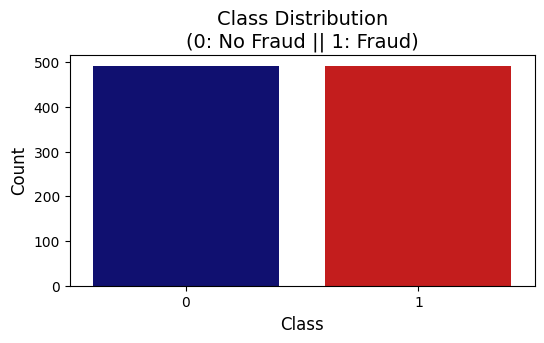

In [12]:
plt.figure(figsize=(6, 3))
colors = ["#000080", "#DF0101"]  # Dark blue for non-fraud, Red for fraud
sns.countplot(x='Class', data=balanced_df, palette=colors)
plt.title('Class Distribution\n(0: No Fraud || 1: Fraud)', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


##### model 02 - training logistic reg. with balanced dataset

Fold 1 - Val AUPRC: 0.9883, Train AUPRC: 0.9914
Fold 2 - Val AUPRC: 0.9807, Train AUPRC: 0.9923
Fold 3 - Val AUPRC: 0.9934, Train AUPRC: 0.9910
Fold 4 - Val AUPRC: 0.9813, Train AUPRC: 0.9928
Fold 5 - Val AUPRC: 0.9738, Train AUPRC: 0.9924

Mean AUPRC: 0.9835 (+/- 0.0135)

Training final model with all balanced data...

Final Model AUPRC on original imbalanced dataset: 0.6830


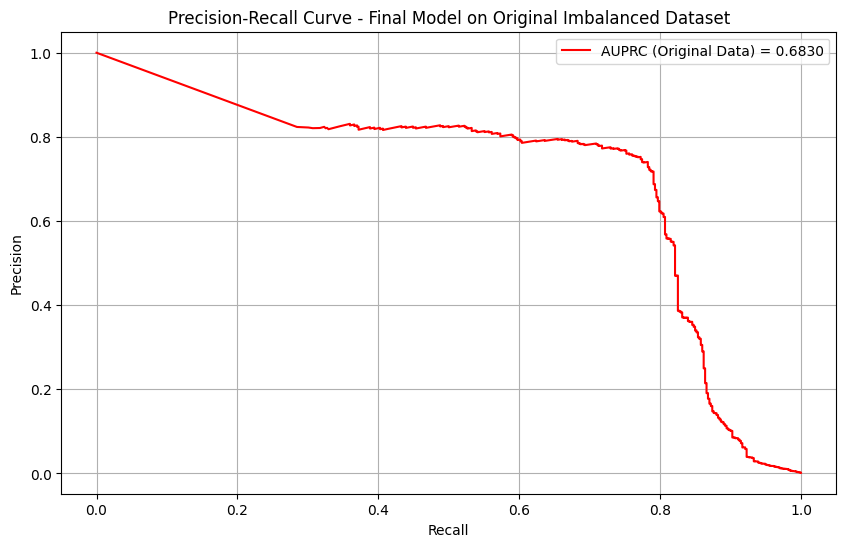

In [14]:
X = balanced_df.drop("Class", axis=1)
y = balanced_df["Class"]
X_orig = df.drop("Class", axis=1)
y_orig = df["Class"]

# Initialize stratified k-fold cross validation
# The critical part is that you do set a random_state to a fixed integer when you
# want your code to produce the same results across multiple runs.
# If you don't set a random_state (or set it to None)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize logistic regression as baseline model
lr_model = LogisticRegression(random_state=42)

# Lists to store precision, recall, AUPRC and F1 scores
precision_scores = []
recall_scores = []
auprc_scores = []
auprc_scores_orig = []

# Perform cross validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    # Split balanced data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Train model
    lr_model.fit(X_train, y_train)

    # Get predictions in balanced dataset
    y_pred_proba = lr_model.predict_proba(X_val)[:, 1]
    y_pred = lr_model.predict(X_val)

    # Calculate metrics - balanced
    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    auprc = average_precision_score(y_val, y_pred_proba)
    auprc_scores.append(auprc)

    # Calculate metrics for training set
    y_train_pred_proba = lr_model.predict_proba(X_train)[:, 1]
    auprc_train = average_precision_score(y_train, y_train_pred_proba)

    print(f"Fold {fold + 1} - Val AUPRC: {auprc:.4f}, Train AUPRC: {auprc_train:.4f}")

print(
    "\nMean AUPRC: {:.4f} (+/- {:.4f})".format(
        np.mean(auprc_scores), np.std(auprc_scores) * 2
    )
)

print("\nTraining final model with all balanced data...")
lr_model.fit(X, y)

# Evaluate on the original imbalanced dataset
y_pred_proba_orig = lr_model.predict_proba(X_orig)[:, 1]
auprc_orig_final = average_precision_score(y_orig, y_pred_proba_orig)
precision_orig, recall_orig, _ = precision_recall_curve(y_orig, y_pred_proba_orig)

print(f"\nFinal Model AUPRC on original imbalanced dataset: {auprc_orig_final:.4f}")

# Plot Precision-Recall curve for the final model on original data
plt.figure(figsize=(10, 6))
plt.plot(recall_orig, precision_orig, color="red", label=f"AUPRC (Original Data) = {auprc_orig_final:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Final Model on Original Imbalanced Dataset")
plt.legend()
plt.grid(True)
plt.show()


It is clear, the model trained with balanced dataset can't handle well the original data

### Anomaly detection

The key idea is remove in the samples, the extreme outliers in the features to see the model in the original dataset improves

- Correlation matrices
We want to know if there are features that influence heavily in whether a specific transaction is a fraud. With the whole dataset is not possible to detect correlations due to the umbalancing.

- 

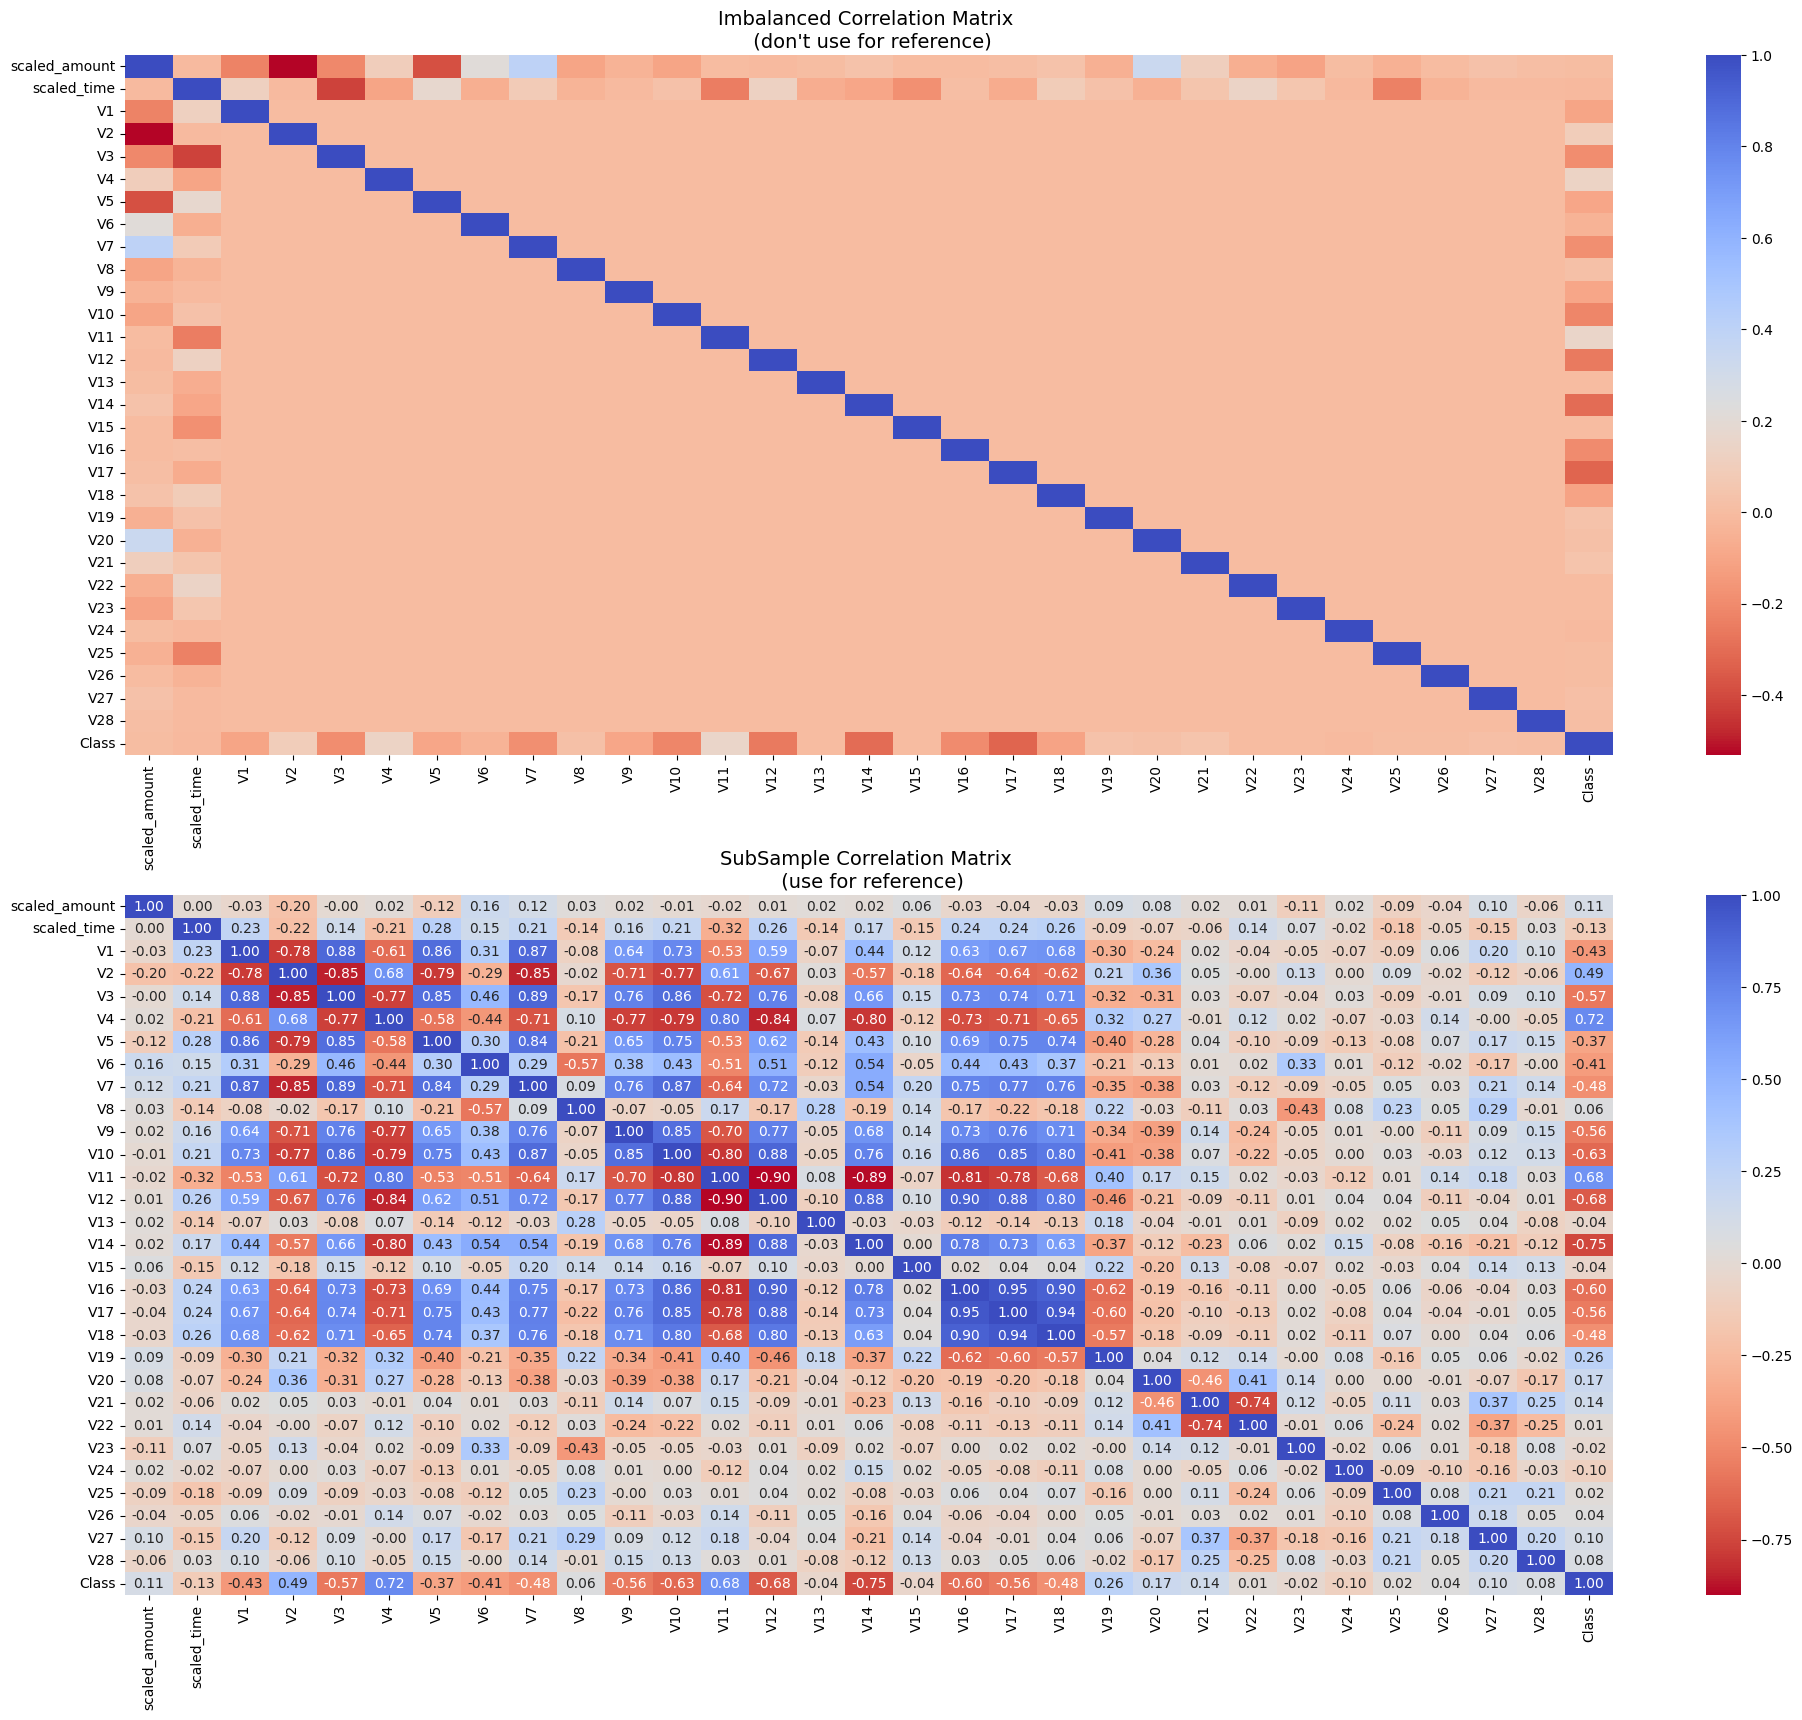

In [15]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

sub_sample_corr = balanced_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':10}, ax=ax2, annot=True, fmt=".2f")
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

Matrices analysis
- When v14, v12, v10 & v16 decrease Class increases ->  Notice how the lower these values are, the more likely the end result will be a fraud transaction
- When v4 & v11 increase, Class increases -> Notice how the higher these values are, the more likely the end result will be a fraud transaction.
- Notice in the original dataset it is difficult to see any correlation.

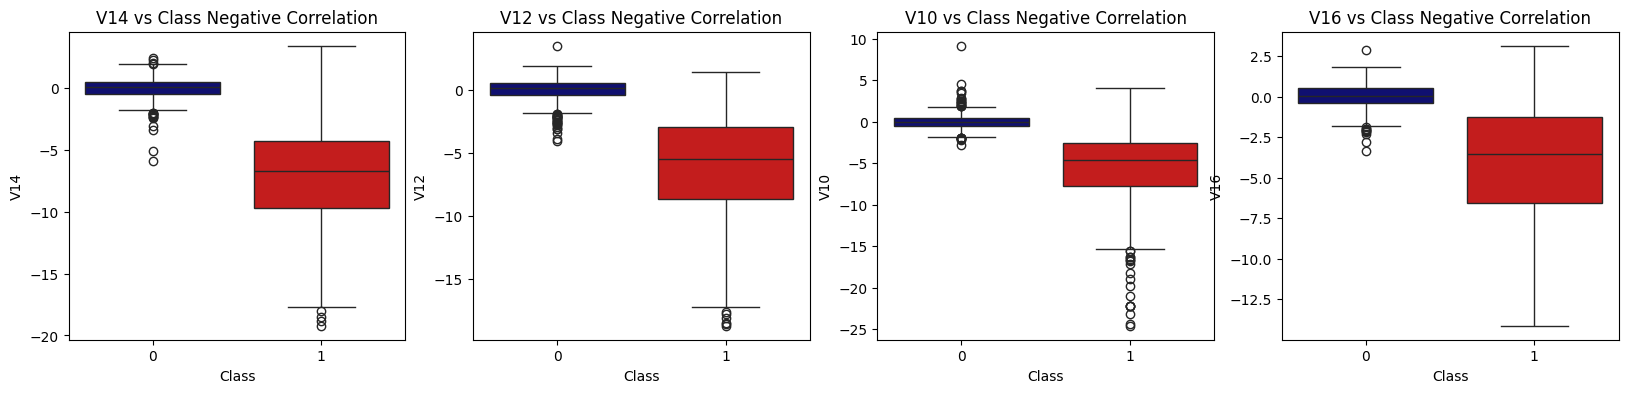

In [18]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V10", data=balanced_df, palette=colors, ax=axes[2])
axes[2].set_title('V10 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V12", data=balanced_df, palette=colors, ax=axes[1])
axes[1].set_title('V12 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=balanced_df, palette=colors, ax=axes[0])
axes[0].set_title('V14 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V16", data=balanced_df, palette=colors, ax=axes[3])
axes[3].set_title('V16 vs Class Negative Correlation')

plt.show()

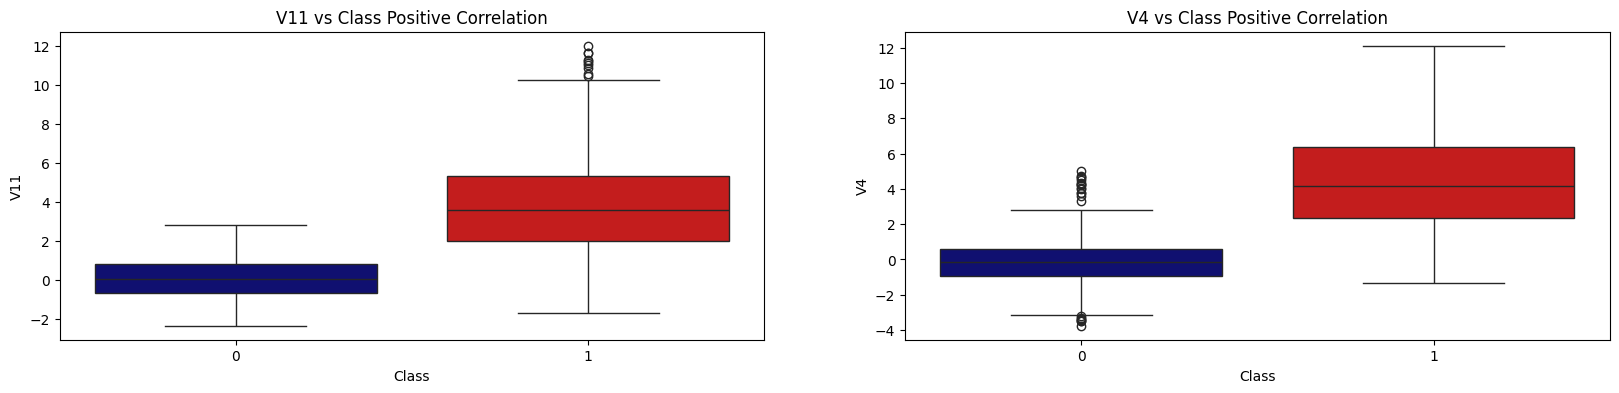

In [19]:

f, axes = plt.subplots(ncols=2, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V4", data=balanced_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V11", data=balanced_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

plt.show()

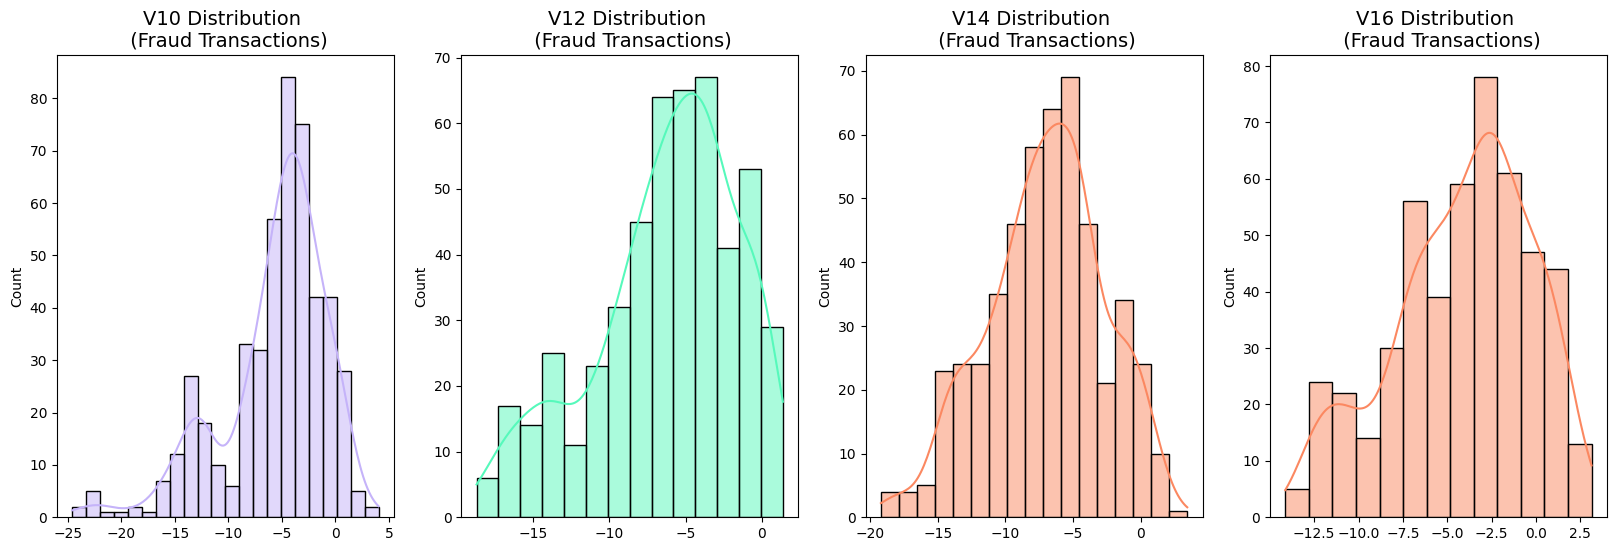

In [26]:
from scipy.stats import norm

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20, 6))

v10_fraud_dist = balanced_df['V10'].loc[balanced_df['Class'] == 1].values
sns.histplot(v10_fraud_dist,ax=ax1, kde=True, color='#C5B3F9')
ax1.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = balanced_df['V12'].loc[balanced_df['Class'] == 1].values
sns.histplot(v12_fraud_dist,ax=ax2, kde=True, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)

v14_fraud_dist = balanced_df['V14'].loc[balanced_df['Class'] == 1].values
sns.histplot(v14_fraud_dist, ax=ax3, color='#FB8861', kde=True)
ax3.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v16_fraud_dist = balanced_df['V16'].loc[balanced_df['Class'] == 1].values
sns.histplot(v16_fraud_dist, ax=ax4, color='#FB8861', kde=True)
ax4.set_title('V16 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

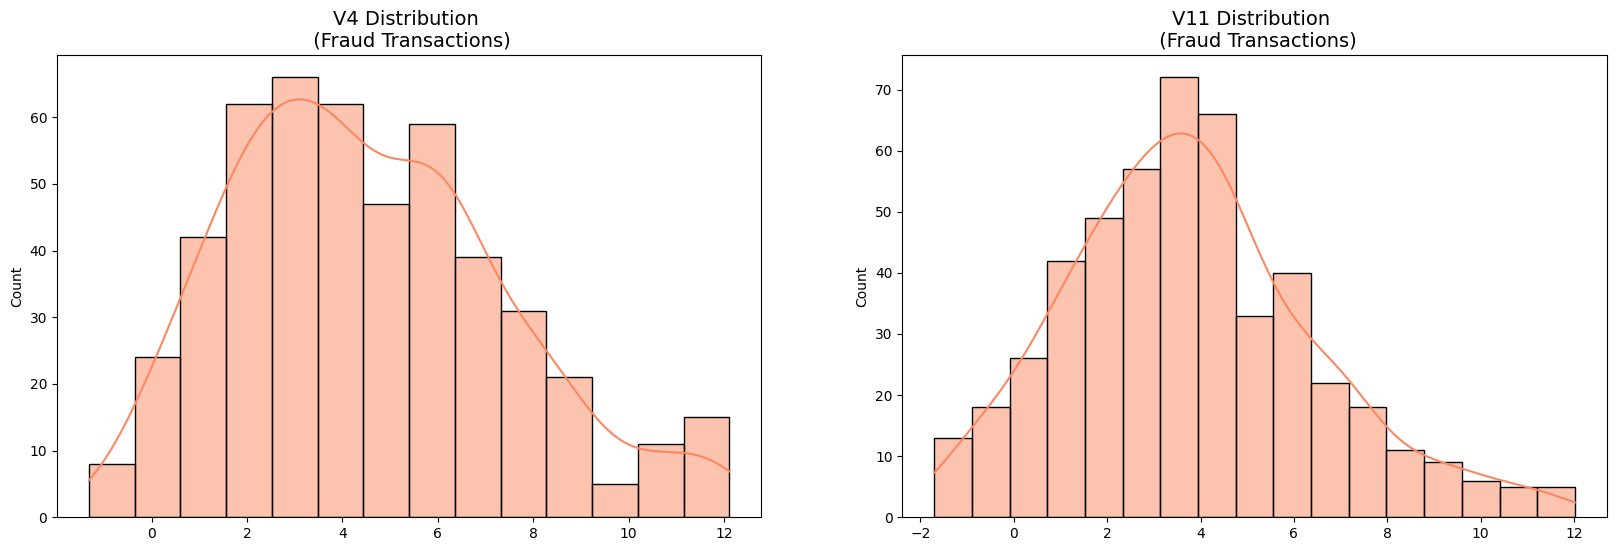

In [27]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))

v4_fraud_dist = balanced_df['V4'].loc[balanced_df['Class'] == 1].values
sns.histplot(v4_fraud_dist, ax=ax1, color='#FB8861', kde=True)
ax1.set_title('V4 Distribution \n (Fraud Transactions)', fontsize=14)

v11_fraud_dist = balanced_df['V11'].loc[balanced_df['Class'] == 1].values
sns.histplot(v11_fraud_dist, ax=ax2, color='#FB8861', kde=True)
ax2.set_title('V11 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

Removing extreme outliers

In [ ]:
print(f"number of frauds: {balanced_df[(balanced_df.Class==1)].shape[0]}")

v14_fraud = balanced_df["V14"].loc[balanced_df["Class"] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
v14_iqr = q75 - q25
v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print("iqr V14: {}".format(v14_iqr), f"v14_cut_off: {v14_cut_off}")

v10_fraud = balanced_df["V10"].loc[balanced_df["Class"] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25
v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print("iqr V10: {}".format(v10_iqr), f"v10_cut_off: {v10_cut_off}")

v12_fraud = balanced_df["V12"].loc[balanced_df["Class"] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25
v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print("iqr V12: {}".format(v12_iqr), f"v12_cut_off: {v12_cut_off}")

v16_fraud = balanced_df["V16"].loc[balanced_df["Class"] == 1].values
q25, q75 = np.percentile(v16_fraud, 25), np.percentile(v16_fraud, 75)
v16_iqr = q75 - q25
v16_cut_off = v16_iqr * 1.5
v16_lower, v16_upper = q25 - v16_cut_off, q75 + v16_cut_off
print("iqr V16: {}".format(v16_iqr), f"v16_cut_off: {v16_cut_off}")

v4_fraud = balanced_df["V4"].loc[balanced_df["Class"] == 1].values
q25, q75 = np.percentile(v4_fraud, 25), np.percentile(v4_fraud, 75)
v4_iqr = q75 - q25
v4_cut_off = v4_iqr * 1.5
v4_lower, v4_upper = q25 - v4_cut_off, q75 + v4_cut_off
print("iqr V4: {}".format(v4_iqr), f"v4_cut_off: {v4_cut_off}")

v11_fraud = balanced_df["V11"].loc[balanced_df["Class"] == 1].values
q25, q75 = np.percentile(v11_fraud, 25), np.percentile(v11_fraud, 75)
v11_iqr = q75 - q25
v11_cut_off = v11_iqr * 1.5
v11_lower, v11_upper = q25 - v11_cut_off, q75 + v11_cut_off
print("iqr V11: {}".format(v11_iqr), f"v11_cut_off: {v11_cut_off}")

balanced_df_outliers = balanced_df.copy()

balanced_df_outliers = balanced_df_outliers.drop(
    balanced_df_outliers[
        (balanced_df_outliers["V14"] > v14_upper)
        | (balanced_df_outliers["V14"] < v14_lower)
    ].index
)
print(f"number of frauds: {balanced_df_outliers[(balanced_df_outliers.Class==1)].shape[0]}")

balanced_df_outliers = balanced_df_outliers.drop(
    balanced_df_outliers[
        (balanced_df_outliers["V10"] > v10_upper)
        | (balanced_df_outliers["V10"] < v10_lower)
    ].index
)
print(f"number of frauds: {balanced_df_outliers[(balanced_df_outliers.Class==1)].shape[0]}")

balanced_df_outliers = balanced_df_outliers.drop(
    balanced_df_outliers[
        (balanced_df_outliers["V12"] > v12_upper)
        | (balanced_df_outliers["V12"] < v12_lower)
    ].index
)
print(f"number of frauds: {balanced_df_outliers[(balanced_df_outliers.Class==1)].shape[0]}")

balanced_df_outliers = balanced_df_outliers.drop(
    balanced_df_outliers[
        (balanced_df_outliers["V16"] > v16_upper)
        | (balanced_df_outliers["V16"] < v16_lower)
    ].index
)
print(f"number of frauds: {balanced_df_outliers[(balanced_df_outliers.Class==1)].shape[0]}")

balanced_df_outliers = balanced_df_outliers.drop(
    balanced_df_outliers[
        (balanced_df_outliers["V4"] > v4_upper)
        | (balanced_df_outliers["V4"] < v4_lower)
    ].index
)
print(f"number of frauds: {balanced_df_outliers[(balanced_df_outliers.Class==1)].shape[0]}")

balanced_df_outliers = balanced_df_outliers.drop(
    balanced_df_outliers[
        (balanced_df_outliers["V11"] > v11_upper)
        | (balanced_df_outliers["V11"] < v11_lower)
    ].index
)
print(f"number of frauds: {balanced_df_outliers[(balanced_df_outliers.Class==1)].shape[0]}")


number of frauds: 492
iqr V14: 5.409902115485521 v14_cut_off: 8.114853173228282
iqr V10: 5.142514314657911 v10_cut_off: 7.713771471986866
iqr V12: 5.714088496427376 v12_cut_off: 8.571132744641064
iqr V16: 5.336871998040352 v16_cut_off: 8.005307997060529
iqr V4: 3.9756799248685306 v4_cut_off: 5.963519887302796
iqr V11: 3.33368093948933 v11_cut_off: 5.000521409233995
number of frauds: 488
number of frauds: 469
number of frauds: 465
number of frauds: 465
number of frauds: 465
number of frauds: 459


Training with the original dataset without the outliers